
Trong notebook này, tôi sẽ thử quy trình lập trình RNN với Keras để phân loại các câu văn bản.

I.   **Trước tiên**, chúng ta sẽ nhập các thư viện hữu ích.

II.   **Sau đó**, chúng ta sẽ load dữ liệu và tạo ma trận word embedding bằng Glove.

III.  **Chúng ta sẽ thử một mô hình RNN đơn giản** rồi đánh giá chất lượng của nó.

IV. Cuối cùng, chúng ta sẽ sử dụng các kỹ thuật để gia tăng độ chính xác của mô hình.

## Liên kết với Google Colab

 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Nhập tất cả các thư viện hữu ích.

In [2]:
# Cài đặt một số thư viện vị thiếu trên Colab

# !pip install tensorflow_addons
# import tensorflow_addons as tfa
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plot
import seaborn as sn
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import keras.models
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_preprocessing import sequence
import tensorflow as tf
import datetime, os
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import sklearn.metrics as metrics

## Định vị dữ liệu trong Google Drive

In [3]:
%cd /content/drive/MyDrive/Text_Classification
%ls
# Ở đây đã được chuẩn bị sẳn 1 file Glove và dữ liệu để train

/content/drive/MyDrive/Text_Classification
glove.6B.50d.txt  train.csv  training_logs/  weights.best.hdf5


## Tạo các đường dẫn

In [4]:
# Liên kết đường dẫn đến thư mục huấn luyện
train="/content/drive/MyDrive/Text_Classification/train.csv"
# Liên kết đến từ điển
glove="/content/drive/MyDrive/Text_Classification/glove.6B.50d.txt"

## Xử lí dữ liệu không cân bằng
Khi kiểm tra dữ liệu thì nhận thấy được dữ liệu đang bị mất cân bằng với nhãn 0 đang chiếm ưu thế. Điều này ảnh hưởng đến chất lượng của mô hình. Để giải quyết vấn đề mất cân bằng dữ liệu, ta tiến hành xử lý như sau:

In [5]:
# Load dữ liệu
'''
Nhằm cải thiện độ chính xác mô hình, ngoài các yêu cầu cơ bản của mô hình 
ta thêm và một bước nữa đó là xử 
lí dữ liệu mất cân bằng
'''
data=pd.read_csv("train.csv")
input=data["question_text"]
label=data["target"]

# Kiểm tra phân bố giá trị của dữ liệu
label.value_counts() # Dữ liệu bị chênh lệch giữa 2 biến 1 và 0

0    1225312
1      80810
Name: target, dtype: int64

In [6]:
# Tiến hành xử lí dữ liệu mất cân bằng
# Sử dụng thư viện imblearn với thuật toán Random Undersampler để loại bỏ lớp bớt dữ liệu lớp đa số

from imblearn.under_sampling import RandomUnderSampler

input=input.values.reshape(-1,1)
label=label.values.reshape(-1,1)
input.shape, label.shape

rus = RandomUnderSampler(
    sampling_strategy='majority',  # samples only the majority class
    random_state=42,  # for reproducibility
    replacement=True # if it should resample with replacement
)  
X_resampled, y_resampled = rus.fit_resample(input,label)

In [7]:
# Lưu dữ liệu đã được xử lí ra DataFrame
data_process=pd.DataFrame()
data_process["question_text"]=X_resampled.reshape(-1,)
data_process["target"]=y_resampled

data_process["question_text"]=X_resampled.reshape(-1,)
data_process["target"]=y_resampled

# Kiểm tra lại dữ liệu
X_resampled.shape, y_resampled.shape

((161620, 1), (161620,))

# II. Load lại dữ liệu.

## Về tập dữ liệu.
Câu hỏi không hợp lệ là những câu hỏi nhằm đưa ra một tuyên bố thay vì tìm kiếm những câu trả lời hữu ích. Một số đặc điểm cho thấy câu hỏi không hợp lệ gồm:

* Có giọng điệu không trung lập.
* Có tính chê bai hoặc kích động.
* Không có căn cứ thực tế.
* Sử dụng nội dung khiêu dâm (loạn luân, thú tính, ấu dâm) để gây sốc, không phải để tìm kiếm câu trả lời xác thực.

Dữ liệu bao gồm câu hỏi đã đề ra và liệu nó có được xác định là không hợp lệ hay không (target = 1).

## Load tập dữ liệu.
* Load dữ liệu từ file CSV.
* Xóa tất cả các hàng có giá trị NA.
* Chia dữ liệu thành 3 tập: Tập huấn luyện, tập kiểm định và tập kiểm tra (0.9/0.05/0.05, random_seed = 9) với cùng một tỷ lệ số dữ liệu giữa mỗi lớp.
* In ra mô tả của tập dữ liệu này.
 



In [8]:
# Load lại dữ liệu

def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set and test_set(0.95/0.05/0.05) without NA values.
    '''
    data=data_link
    data = data.rename(columns={'target': 'label'})
    train, val_test= train_test_split(data[["question_text","label"]],stratify=data["label"] ,test_size = 0.05,  random_state = 0)
    validation, test=train_test_split(val_test[["question_text","label"]],stratify=val_test["label"] , test_size = 0.5,  random_state = 0)
    return train, validation, test

train_set, validation_set, test_set = load_data(data_process)
print(train_set['label'].describe())
print(validation_set['label'].describe())
print(test_set['label'].describe())

count    153539.000000
mean          0.500003
std           0.500002
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64
count    4040.000000
mean        0.500000
std         0.500062
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: label, dtype: float64
count    4041.000000
mean        0.499876
std         0.500062
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64


In [9]:
# Kiểm tra kích thước các  dữ liệu train test val
print(len(train_set["label"]))
print(len(validation_set["label"]))
print(len(test_set["label"]))

153539
4040
4041


# Mã hóa dữ liệu văn bản.
Hãy khai báo một số tham số cơ bản trước:

In [10]:
embed_size = 50 # mỗi vectơ từ lớn bao nhiêu
max_features = 20000 # cần sử dụng bao nhiêu từ duy nhất (tức là số hàng trong vectơ embedding)
max_len = 50 # sử dụng số từ tối đa trong câu hỏi

## Mã hóa tập dữ liệu bằng Tokenizer và vectơ biểu diễn one-hot.
* Mã hóa văn bản (cột question_text) bằng cách chuyển từng question text thành danh sách chỉ mục từ bằng [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) với **max_features** và tất cả các câu văn bản từ tập huấn luyện và tập kiểm định.
* Chuyển từng danh sách chỉ mục từ thành độ dài như nhau - **max_len** (có cắt tỉa hoặc đệm nếu cần) bằng cách sử dụng [pad_sequences](https://keras.io/preprocessing/sequence/).
* Mã hóa nhãn (cột nhãn) bằng cách sử dụng hàm [to_categorical](https://keras.io/utils/) trong Keras.

In [11]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    tokenizer = Tokenizer(num_words=max_features)
    data=pd.concat([train_set, validation_set])
    tokenizer.fit_on_texts(data["question_text"])

    train_token = tokenizer.texts_to_sequences(train_set["question_text"])
    val_token = tokenizer.texts_to_sequences(validation_set["question_text"])    
    test_token = tokenizer.texts_to_sequences(test_set["question_text"])

    X_tr=pad_sequences(train_token, maxlen= max_len)
    X_va=pad_sequences(val_token, maxlen= max_len)   
    # X_te=test_set["question_text"] 
    X_te=pad_sequences(test_token, maxlen= max_len)  

    y_tr,y_va,y_te=train_set["label"], validation_set["label"], test_set["label"]
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer   

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

### Tạo ma trận word embedding.
* Đầu tiên, tạo một hàm để load [GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Sau đó, tạo ma trận word embedding bằng GloVe dictionary với các tham số sau:
    - Shape của ma trận word embedding: (Number of word, embed_size).
    - Embed size: 50. 
    - Number of words: Tối thiểu của (max_features, len(word_index)), trong khi word_index là dictionary của từ chứa trong tokenizer.
    - Nếu một từ xuất hiện trong GloVe dictionary, chúng ta nên lấy giá trị khởi tạo của nó như trong GloVe dictionary. Nếu không, hãy lấy một giá trị ngẫu nhiên bình thường với mean và std làm mean và std của giá trị GloVe dictionary.
    



In [12]:
# Number_of_words=min(max_features,len(word_index))

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    lines=0
    embeddings_index = {}
    with open(GloVe_link) as f:
        for line in f:
            values = line.split()
            word = values[0]            
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
            lines+=1
    return  embeddings_index ,lines        
GloVe_link = 'glove.6B.50d.txt'
GloVe_dict,line = get_GloVe_dict(GloVe_link)

In [13]:
# Tính toán mean và std của Glove
values=[]
data_value_of_golve=pd.DataFrame(columns=["values"])   
for i in GloVe_dict.values():
    values.append(i)
value=np.array(values)
data_value_of_golve["values"]=GloVe_dict.values()
mean=data_value_of_golve["values"].mean()
array_std=np.array(data_value_of_golve["values"].values)
array_std=array_std.reshape(-1,50)
std=array_std.std()

def initialization_vector(mean,std):
    """
    Nếu một từ xuất hiện trong GloVe dictionary, chúng ta nên 
    lấy giá trị khởi tạo của nó như trong GloVe dictionary. 
    Nếu không, hãy lấy một giá trị ngẫu nhiên bình thường với
    mean và std làm mean và std của giá trị GloVe dictionary.
    """
    initialization_vector = np.random.normal(loc=mean, scale=std, size=50)
    return initialization_vector

def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embed_size))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = GloVe_dict.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i]=initialization_vector(mean,std)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

# III. Lập mô hình
Chúng ta cần hoàn thành một số bước: 

Xây dựng mô hình.

Biên dịch mô hình.

Huấn luyện/khớp dữ liệu với mô hình.

Đánh giá mô hình trên tập kiểm tra.

## Xây dựng mô hình Chúng ta có thể xây dựng một mô hình dễ dàng gồm các layer khác nhau như:
* Layer [Embedding](https://keras.io/layers/embeddings/) với max_features, embed_size và embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/nlp/bidirectional_lstm_imdb/?fbclid=IwAR3fEd6aWyeIDEhZSspjtCRiP0c0Jnz5-XdnUHQYwX8Tp8k9Ni4I8Q5tP9o) với số lượng trạng thái ẩn = 50, dropout_rate = 0.1 và recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense với số nút = 50, activation = 'relu'.
* Dropout với rate = 0.1.
* Final dense với số nút = số class, activation = 'sigmoid'.

In [14]:
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## TYPE YOUR CODE for task 7 here:
    model = keras.Sequential()
    embedding_layer= layers.Embedding(
                          input_dim=embedding_matrix.shape[0], # thiết lập shape đầu vào
                          output_dim=embed_size, # thiết lập kích thước của vectơ embedding
                          embeddings_initializer="uniform", # mặc định, khởi tại ngẫu nhiên
                          weights=[embedding_matrix],
                          input_length=max_len, # mỗi đầu vào dài bao nhiêu
                          # trainable=False,
                          name="embedding") 
    
    # text_vectorizer = TextVectorization(max_tokens=None, # có bao nhiêu từ trong từ vựng (toàn bộ các từ khác nhau trong text)
    #                                 standardize="lower_and_strip_punctuation", # cách xử lý text
    #                                 split="whitespace", # cách phân chia token
    #                                 ngrams=None, # có tạo nhóm n-từ không?
    #                                 output_mode="int", # cách ánh xạ token thành số
    #                                 output_sequence_length=None)
    
    model.add(layers.Input(shape=(50,)))
    # model.add(text_vectorizer)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(50,return_sequences=True)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(50,activation="relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation="sigmoid"))   
    
    return model

model = create_model(max_len, max_features, embed_size)

## Biên dịch mô hình và thiết lập callback. Sau đó in ra model summary.
* [Biên dịch](https://keras.io/models/model/#compile) mô hình với Adam Optimizer, lr = 1e-2, loss phù hợp cho bài toán phân loại nhị phân và ["F1-score"](https://github.com/tensorflow/addons/issues/825) là phép đo.
* In ra model summary.

In [15]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['acc',f1_metric])
    return model

model = optimize(model)

Thiết lập callback.
* Tạo [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) để lưu logs.
* Tạo [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
* Tạo [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
* Tạo [early stopping callback](https://keras.io/callbacks/#earlystopping) với patience=7, mode = 'max' và "Validation F1-score" monitor.



In [17]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Checkpoint name, logs name tốt nhất.
    Return: 
        Callback list có chứa tensorboard callback và checkpoint callback.
    '''
    #Tensorboard
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    tensorboard_callback=tf.keras.callbacks.TensorBoard(logs_name, histogram_freq=1)
    #Early_Stopping
    early_stopping = EarlyStopping(monitor = 'val_f1_metric',
                               patience = 7,
                               mode = 'max',
                               restore_best_weights = True)

    # Save the model with the minimum validation loss
    checkpoint = ModelCheckpoint(checkpoint_name,monitor = 'val_f1_metric',verbose = 1,mode = 'max', save_best_only = True)

    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_f1_metric',factor = 0.3,patience = 1)

    callbacks_list=[tensorboard_callback,checkpoint,reduce_lr,early_stopping]                              
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

##Huấn luyện mô hình.

* Huấn luyện mô hình với 20 epoch với batch_size = 4096.
* Trả về mô hình có trọng số checkpoint tốt nhất.

*Gợi ý*: Trước tiên hãy khớp mô hình, sau đó reload mô hình (hàm load_model) với trọng số checkpoint tốt nhất.

In [18]:
def train_model(model, callbacks_list):
    '''
    Input: 
        Mô hình và callback list,
    Return: 
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    model.fit(X_tr,
              y_tr,              
              epochs=15,
              batch_size = 4096,
              validation_data=(X_va,y_va),
              callbacks=callbacks_list
              )
    return model

model = train_model(model, callbacks_list)

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.4068 - acc: 0.8153 - f1_metric: 0.8142
Epoch 1: val_f1_metric improved from -inf to 0.89627, saving model to weights.best.hdf5
38/38 [==============================] - 91s 2s/step - loss: 0.4068 - acc: 0.8153 - f1_metric: 0.8142 - val_loss: 0.2681 - val_acc: 0.8941 - val_f1_metric: 0.8963 - lr: 0.0100
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.2569 - acc: 0.9016 - f1_metric: 0.9027
Epoch 2: val_f1_metric improved from 0.89627 to 0.90785, saving model to weights.best.hdf5
38/38 [==============================] - 85s 2s/step - loss: 0.2569 - acc: 0.9016 - f1_metric: 0.9027 - val_loss: 0.2484 - val_acc: 0.9064 - val_f1_metric: 0.9078 - lr: 0.0100
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.2238 - acc: 0.9175 - f1_metric: 0.9183
Epoch 3: val_f1_metric did not improve from 0.90785
38/38 [==============================] - 83s 2s/step - loss: 0.2238 - acc: 0.9175 - f1_met

## Hiển thị tensorboard trong notebook.

In [20]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Classification_Toxic_Comment" \
  --description "The Last Training" \
  --one_shot

2022-08-18 07:41:16.313464: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3A

## Dự đoán trên tập kiểm tra.

* Hoàn thành hàm get_prediction_classes.
* In ra precision, recall và F1 score.

In [21]:
def get_prediction_classes(model, X, y):
    '''
    Input: 
        Mô hình và tập dữ liệu dự đoán. 
    Return: 
        Prediction list và groundtrurth list với predicted classes. 
    '''
    predictions=model.predict(X)
    predictions=np.around(predictions,0)
    groundtruths=y.values
    groundtruths=groundtruths.reshape(-1,1)
    return predictions, groundtruths

test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_predictions, test_groundtruths))
print(recall_score(test_predictions, test_groundtruths))
print(f1_score(test_predictions, test_groundtruths))

127/127 [==============================] - 2s 11ms/step
0.9173267326732674
0.8832221163012393
0.8999514327343371


## Thực hiện kết quả dự đoán trên tập kiểm tra bằng cách sử dụng ma trận nhầm lẫn. Hãy nhớ hiển thị tên lớp trong ma trận nhầm lẫn.

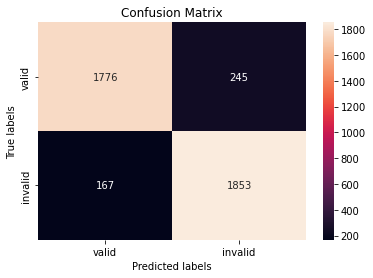

In [22]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## TYPE YOUR CODE for task 13 here:    
    cf=metrics.confusion_matrix(groundtruth,predictions)
    ax= plot.subplot()
    sn.heatmap(cf, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names)
class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)